In [99]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader,Subset
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from process_pipeline import *
import pandas as pd
from datetime import datetime
from datetime import timedelta
import copy
from scipy.spatial.distance import cosine

In [100]:
file_path = ".\data\database.xlsx"
df = pd.read_excel(file_path,'Feuil3')
Cmd = df.to_numpy()

file_conso_path = ".\data\THHeating.xlsx"
cg = pd.read_excel(file_conso_path)
cg = cg.to_numpy()

file_conso_path = ".\data\TH.xlsx"
cw = pd.read_excel(file_conso_path)
cw = cw.to_numpy()


file_conso_path = ".\data\ThForElec.xlsx"
ce = pd.read_excel(file_conso_path)
ce = ce.to_numpy()

C:\Users\hugom\OneDrive\Documents\Sensorea_AI\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\hugom\OneDrive\Documents\Sensorea_AI\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\hugom\OneDrive\Documents\Sensorea_AI\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# transformation et fusion des dataframe

In [101]:

for i in range(len(cw)):
    cw[i][0] = datetime.strftime(cw[i][0],"%d/%m/%Y %H:%M:%S")

for i in range(len(cg)):
    cg[i][0] = datetime.strftime(cg[i][0],"%d/%m/%Y %H:%M:%S")

for i in range(len(ce)):
    ce[i][0] = datetime.strftime(ce[i][0],"%d/%m/%Y %H:%M:%S")

In [102]:
start_time = datetime.strptime(Cmd[-1][0], "%d/%m/%Y %H:%M:%S")
stop_time = datetime.strptime(Cmd[0][0], "%d/%m/%Y %H:%M:%S")
print(start_time)
print(stop_time)
Ps = timedelta(days=0, hours=0, minutes=5, seconds=0)

2025-08-15 19:20:23
2025-08-18 23:59:54


In [103]:
def sampling(data,start_time,stop_time,Ps):
    dates = copy.deepcopy(data[:,0])
    for i in range(len(dates)):
        dates[i] = datetime.strptime(dates[i], "%d/%m/%Y %H:%M:%S")
    dt = stop_time - start_time
    X = [[start_time+i*Ps] for i in range(int(dt/Ps))]
    for i in range(len(X)):
        k,_ = min(enumerate(dates), key=lambda x:abs(x[1]-X[i][0]))
        X[i].extend(data[k][1:])
    return np.array(X)
Cmd = sampling(Cmd,start_time,stop_time,Ps)
Cmd[:,1:] = Cmd[:,1:]/100
cw = sampling(cw,start_time,stop_time,Ps)
cg = sampling(cg,start_time,stop_time,Ps)
ce = sampling(ce,start_time,stop_time,Ps)

In [104]:
import requests
def get_temp(date_datetime,lat =50.8503, lon = 4.3517):
    date = str(date_datetime)
    date = date.split(" ")
    date = date[0]
    url = (
        f"https://archive-api.open-meteo.com/v1/archive"
        f"?latitude={lat}&longitude={lon}"
        f"&start_date={date}&end_date={date}"
        f"&hourly=temperature_2m"
    )

    response = requests.get(url)
    data = response.json()
    temps = data['hourly']['temperature_2m']
    timestamps = data['hourly']['time']

    datatimes = [datetime.strptime(stamps, "%Y-%m-%dT%H:%M") for stamps in timestamps]
    k,_ = min(enumerate(datatimes), key=lambda x:abs(x[1]-date_datetime))
    return temps[k]

In [105]:
dataframe = []
for i in range(len(Cmd)):
    frame = []
    frame.extend(Cmd[i])
    frame.append(cw[i][1])
    frame.append(ce[i][1])
    frame.append(cg[i][2])
    frame.append(get_temp(Cmd[i,0]))
    frame.append(0.0)#on mettra l'occupation plus tard
    dataframe.append(frame)
dataframe = np.array(dataframe)
print(dataframe.shape)

(919, 15)


# definition des fonction des pipelines

### si on vient de la base de données ont commence d'ici le data ont la forme : [date,Cmd,water,elec,gaz]

In [106]:
def windowing(dataframe,window_size):
    output = []
    for i in range(0,len(dataframe)-window_size,1):
        output.append(dataframe[i:i+window_size])
    return np.array(output)
def datetime_to_sin(dataframe):
    tempframe = copy.deepcopy(dataframe).tolist()
    for i in range(len(dataframe)):
        hour   = tempframe[i][0].hour
        day_of_year = tempframe[i][0].timetuple().tm_yday
        theta_hour = 2*np.pi*(hour/24)
        theta_day = 2*np.pi*(day_of_year/365)
        tempframe[i] = tempframe[i][1:]
        tempframe[i].append(float(np.sin(theta_hour)))
        tempframe[i].append(float(np.cos(theta_hour)))
        tempframe[i].append(float(np.sin(theta_day)))
        tempframe[i].append(float(np.cos(theta_day)))
    return np.array(tempframe)


In [107]:
def output_give_up(dataframe):
    tempframe = copy.deepcopy(dataframe).tolist()
    for i in range(len(tempframe)):
        tempframe[i]=tempframe[i][:-1]
    return np.array(tempframe)

In [108]:
def sim(dataframe,W,threshold):
    targets = []
    tempframe = copy.deepcopy(dataframe)

    for i in range(len(dataframe)):
        cos_dist = [cosine(x[-1][12:]*W,tempframe[i][-1][12:]*W) for x in tempframe]
        target = tempframe[i][-1]
        for j in range(len(cos_dist)):
            if cos_dist[j] < threshold:
                if tempframe[j][-1][11]<=target[11]:
                    target = tempframe[j][-1]
        targets.append(target[:9])
    return np.array(targets)


# création pipeline

In [109]:
Inputs_pipeline = preprocessing_pipeline()
Inputs_pipeline.join(datetime_to_sin,"father","datetime_to_sin",{})
Inputs_pipeline.join(windowing,"datetime_to_sin","windowing",{"window_size":21})
Inputs_pipeline.join(output_give_up,"windowing","last layer give up",{})
Inputs_pipeline.rendering(dataframe)
pipe = Inputs_pipeline.fit()
Inputs_pipeline.save("C:/Users\hugom\OneDrive\Documents\Sensorea_AI\X_pipeline")
X = torch.tensor(pipe(dataframe)).float()

└── [0──node : father────────────────────────────────
├── [1──node : datetime_to_sin──input_shape : [(919, 15)]──output_shape : [(919, 18)]
├── [2──node : windowing──input_shape : [(919, 18)]──output_shape : [(898, 21, 18)]
├── [3──node : last layer give up──input_shape : [(898, 21, 18)]──output_shape : [(898, 20, 18)]


In [110]:
output_pipeline = preprocessing_pipeline()
output_pipeline.join(datetime_to_sin,"father","datetime_to_sin",{})
output_pipeline.join(windowing,"datetime_to_sin","windowing",{"window_size":21})
output_pipeline.join(sim,"windowing","sim_search",{"W":np.array([0.5,0.0,0.125,0.125,0.125,0.125]),"threshold":0.0002})
output_pipeline.rendering(dataframe)
pipe = output_pipeline.fit()
output_pipeline.save("C:/Users\hugom\OneDrive\Documents\Sensorea_AI\y_pipeline")
y = torch.tensor(pipe(dataframe)).float()

└── [0──node : father────────────────────────────────
├── [1──node : datetime_to_sin──input_shape : [(919, 15)]──output_shape : [(919, 18)]
├── [2──node : windowing──input_shape : [(919, 18)]──output_shape : [(898, 21, 18)]
├── [3──node : sim_search──input_shape : [(898, 21, 18)]──output_shape : [(898, 9)]


# entrainement

## LSTM

In [111]:
class LSTM(nn.Module):
    def __init__(self,in_channels,out_channels,hidden=[128,64]):
        super(LSTM, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels,hidden[0]),
            nn.ReLU(),
        )
        self.lstm = nn.LSTM(hidden[0],hidden[1],batch_first=True)
        self.head = nn.Sequential(nn.Linear(hidden[1],out_channels),
                                  nn.Sigmoid())
    def forward(self, x):
        x = self.mlp(x)
        x, (h_n, c_n) = self.lstm(x)
        x = x[:,-1,:]
        x = self.head(x)
        return x
model = LSTM(18,9)
optimizer  = optim.Adam(model.parameters(), lr=0.5e-4)
criterion = nn.MSELoss()

In [112]:
compiler_LSTM = pytorch_compiler(model,optimizer, criterion,1200,32)

In [113]:
model,train_losses,val_losses = compiler_LSTM.fit(X,y)

├── nombre de fichiers d'entrainement : 718
├── nombre de fichiers de test : 180


training: 100%|██████████| 1200/1200 [02:21<00:00,  8.48it/s, train_loss=0.00292, val_loss=0.00191]


In [114]:
torch.save({
    "model_state": model.state_dict(),
    "in_channels": 18,
    "out_channels": 9,
    "hidden": (128, 64)
}, "lstm_model.pt")

# Analyse de la convergence

$$
\mathrm{MSE}
= \frac{1}{N\,D}
\sum_{n=1}^{N}
\sum_{d=1}^{D}
\left(\hat{y}_{n,d} - y_{n,d}\right)^2
$$



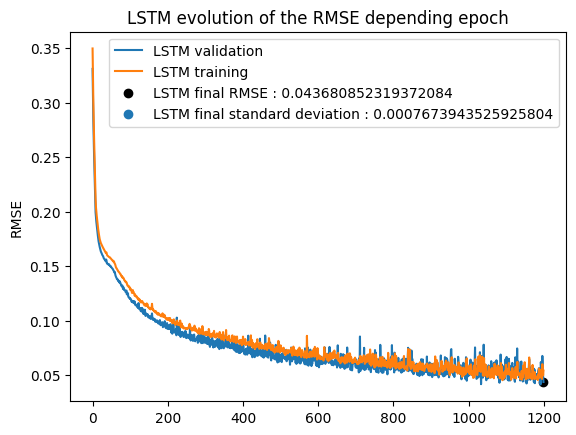

In [115]:
x = [i for i in range(len(train_losses))]
LSTM_RMSE_val = np.sqrt(val_losses)
LSTM_Std_val = LSTM_RMSE_val/np.sqrt(2*180*9)
LSTM_RMSE_train = np.sqrt(train_losses)
plt.plot(x,LSTM_RMSE_val,label="LSTM validation")
plt.plot(x,LSTM_RMSE_train,label="LSTM training")
plt.scatter(len(val_losses)-1,LSTM_RMSE_val[-1],label=f"LSTM final RMSE : {LSTM_RMSE_val[-1]}",color="black")
plt.scatter([],[],label=f"LSTM final standard deviation : {LSTM_Std_val[-1]}")
plt.ylabel("RMSE")
plt.title("LSTM evolution of the RMSE depending epoch")
plt.legend()
plt.savefig("LSTM_RMSE_val_5min_sim0.0002_input18_wo_occ.png")
plt.show()


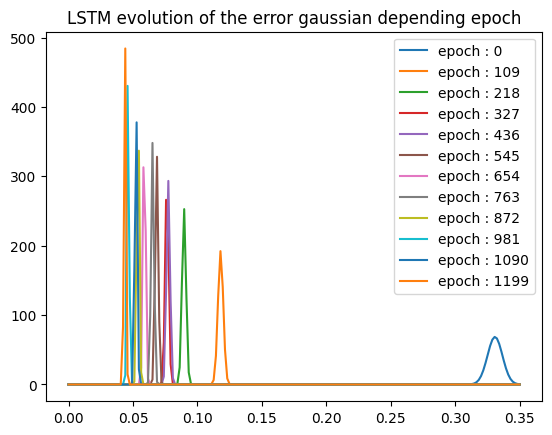

In [116]:
def gaussian(x, mu=0.0, sigma=1.0):
    return np.exp(-0.5 * ((x - mu) / sigma)**2) / (sigma * np.sqrt(2*np.pi))
for i in range(0,len(LSTM_RMSE_val),109):
    x = np.linspace(0, 0.35, 200)
    y = gaussian(x, mu=LSTM_RMSE_val[i], sigma=LSTM_Std_val[i])
    plt.plot(x,y,label=f"epoch : {i}")
plt.title("LSTM evolution of the error gaussian depending epoch")
plt.legend()
plt.savefig("LSTM_gaussian_val_5min_sim0.0002_input18_wo_occ.png")
plt.show()

# test prediction

load model


In [117]:
param = torch.load("lstm_model.pt")
model_state = param["model_state"]
in_channels = param["in_channels"]
out_channels = param["out_channels"]
# ne pas oublier de définir la classe avant d'import
model_test = LSTM(in_channels,out_channels)
model_test.load_state_dict(model_state)
model_test.eval()

LSTM(
  (mlp): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
  )
  (lstm): LSTM(128, 64, batch_first=True)
  (head): Sequential(
    (0): Linear(in_features=64, out_features=9, bias=True)
    (1): Sigmoid()
  )
)

création pipeline d'adaptation des données

In [124]:
test_pipeline = preprocessing_pipeline()
test_pipeline.join(datetime_to_sin,"father","datetime_to_sin",{})
test_pipeline.rendering(dataframe[0:20])
test_pipe = test_pipeline.fit()
test_pipeline.save("C:/Users\hugom\OneDrive\Documents\Sensorea_AI/test_pipeline")
#exemple d'appel
x_test = dataframe[0:20]
test_X = torch.tensor(test_pipe(x_test)).float()

└── [0──node : father────────────────────────────────
├── [1──node : datetime_to_sin──input_shape : [(20, 15)]──output_shape : [(20, 18)]


In [119]:
def predict(model,x):
    x = x.unsqueeze(0)
    y_pred = model(x)
    return y_pred
print(predict(model_test,test_X))

tensor([[5.0109e-01, 5.5616e-05, 6.9922e-01, 5.7517e-05, 6.9798e-01, 5.6817e-05,
         6.6814e-01, 6.4393e-01, 6.9431e-01]], grad_fn=<SigmoidBackward0>)


In [123]:
torch.save({"dataframe":dataframe},"dummy.pt")

In [1]:
from model_utils import *
dummy = torch.load("dummy.pt", weights_only=False)
dataframe = dummy["dataframe"]
train(dataframe)

├── nombre de fichiers d'entrainement : 718
├── nombre de fichiers de test : 180


training: 100%|██████████| 1200/1200 [02:32<00:00,  7.85it/s, train_loss=0.00224, val_loss=0.00305]
